# Running pyBOA on b

In [88]:
# imports
from importlib import reload
import os

import numpy as np
import h5py
import xarray
import pandas

from matplotlib import pyplot as plt

from skimage import morphology

from wrangler.plotting import cutout
from wrangler.ogcm import llc as wr_llc

from fronts.pyboa import pyBOA
from fronts.llc import extract

# Load up training data

In [2]:
## B = Inputs = Div SST, SSS, SST 
        #   Targets = Divb2 

In [6]:
b_tblfile = os.path.join(os.getenv('OS_OGCM'), 'LLC', 'Fronts', 'Training_Sets', 
                     'LLC4320_SST144_SSS40_trainB.parquet')
b_file = os.path.join(os.getenv('OS_OGCM'), 'LLC', 'Fronts', 'Training_Sets', 
                     'LLC4320_SST144_SSS40_trainB.h5')

In [4]:
b_train = h5py.File(b_file, 'r')
b_train.keys()

<KeysViewHDF5 ['inputs', 'targets']>

In [9]:
b_tbl = pandas.read_parquet(b_tblfile)
b_tbl.iloc[500]

lat                                                  -28.979555
lon                                                  -158.90625
row                                                        6310
col                                                       11444
datetime                                    2011-12-25 00:00:00
UID                                           13246102042109375
filename      /data/Projects/Oceanography/data/LLC/ThetaUVSa...
pp_file                                                        
pp_root                       llc4320_sst144_sss40_extract.json
field_size                                                   64
pp_type                                                       0
SSTmax                                                24.571771
SSTmin                                                22.414863
SST10                                                 23.131249
SST90                                                 24.349434
SSTmu                                   

## Load up cutout

In [14]:
idx = 500
cut_tbl = b_tbl[idx:idx+1]
cut_tbl

,lat,lon,row,col,datetime,UID,filename,pp_file,pp_root,field_size,...,SSSmax,SSSmin,SSS10,SSS90,SSSmu,Divb2max,Divb2min,Divb210,Divb290,Divb2mu
971122,-28.979555,-158.90625,6310,11444,2011-12-25,13246102042109375,/data/Projects/Oceanography/data/LLC/ThetaUVSa...,,llc4320_sst144_sss40_extract.json,64,...,35.403801,35.240265,35.254714,35.371112,35.304237,1.846134e-13,6.646706e-18,2.137832e-16,1.654070e-14,7.396012e-15


In [15]:
pdict = {
            "field_size": 64,
            "fixed_km": 144.0
        }

In [22]:
reload(extract)
llc_table, success, pp_fields, final_meta = extract.preproc_field(cut_tbl, 'b', pdict)#, test_process=True)

Cutouts loaded for /home/xavier/Oceanography/data/OGCM/LLC/data/ThetaUVSalt/LLC4320_2011-12-25T00_00_00.nc


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 1513.64it/s]


In [23]:
pp_fields

array([[[0.0097915 , 0.00979142, 0.0097913 , ..., 0.00979065,
         0.00979064, 0.00979069],
        [0.00979146, 0.00979134, 0.00979123, ..., 0.00979076,
         0.00979068, 0.0097907 ],
        [0.00979142, 0.00979128, 0.00979118, ..., 0.00979097,
         0.00979087, 0.00979075],
        ...,
        [0.00978731, 0.00978741, 0.00978758, ..., 0.00978766,
         0.00978778, 0.00978789],
        [0.00978721, 0.00978736, 0.00978756, ..., 0.00978765,
         0.00978779, 0.00978793],
        [0.0097872 , 0.00978736, 0.00978754, ..., 0.0097877 ,
         0.00978785, 0.00978797]]], shape=(1, 64, 64))

## Rerun Divb^2 too, just in case

In [40]:
pdict2 = {
                "dx": 2.25,
            "field_size": 64,
            "fixed_km": 144.0
        }
llc_table, success, pp_fields2, final_meta = extract.preproc_field(cut_tbl, 'Divb2', pdict2)#, test_process=True)

Cutouts loaded for /home/xavier/Oceanography/data/OGCM/LLC/data/ThetaUVSalt/LLC4320_2011-12-25T00_00_00.nc


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 3132.42it/s]


In [41]:
def parse_idx(idx):
    # Parase
    div_sst = b_train['inputs'][idx, 0, 0, ...]
    sst = b_train['inputs'][idx, 2, 0, ...]
    sss = b_train['inputs'][idx, 1, 0, ...]
    #
    Divb2 = b_train['targets'][idx, 0, 0, ...]
    #
    return div_sst, sst, sss, Divb2

In [25]:
def plot_example(idx):
    div_sst, sst, sss, Divb2 = parse_idx(idx)

    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    cutout.show_image(sst, clbl='SST (deg C)', ax=ax1)
    cutout.show_image(div_sst, clbl=r'|Div SST|$^2$', cm='viridis', ax=ax2)
    #cutout.show_image(sss, clbl='SSS (psu)', cm='viridis', ax=ax2)
    cutout.show_image(Divb2, clbl=r'$\nabla b^2$', cm='Greys', ax=ax3)
    #
    plt.show()

In [26]:
def arr_to_dataset(arr):
    ds = xarray.Dataset({
    'data': (['x', 'y'], arr)}, coords={
    'x': range(arr.shape[0]),  # 0, 1, 2, ..., 9
    'y': range(arr.shape[1]),  # 0, 1, 2, 3, 4
    })
    return ds

# Try it

## Pick one

In [27]:
idx = 500
div_sst, sst, sss, Divb2 = parse_idx(idx)

### Plot it

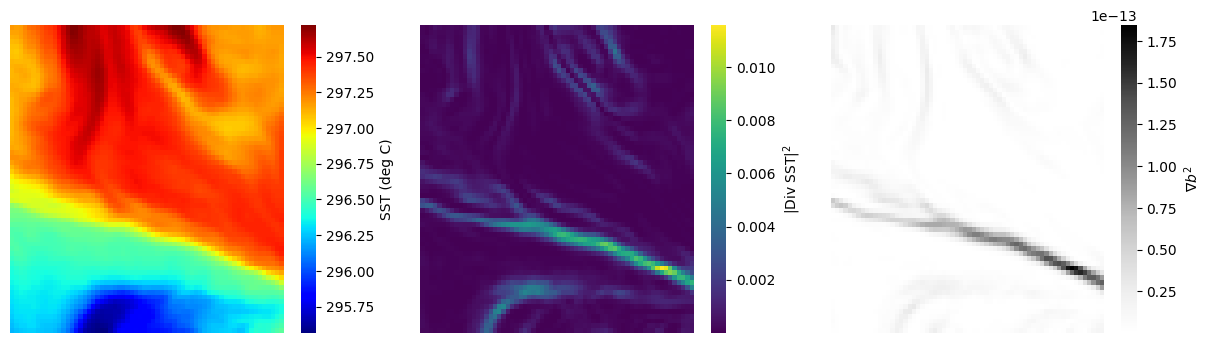

In [28]:
plot_example(idx)

## PyBOA

## Recast density as xarray.DataArray

In [29]:
b_ds = arr_to_dataset(pp_fields[0])
b_ds

<xarray.Dataset> Size: 34kB
Dimensions:  (x: 64, y: 64)
Coordinates:
  * x        (x) int64 512B 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63
  * y        (y) int64 512B 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63
Data variables:
    data     (x, y) float64 33kB 0.009791 0.009791 ... 0.009788 0.009788

In [20]:
## Instantiate and run

In [45]:
reload(pyBOA)
pyboa = pyBOA.pyBOA(b_ds)

/mnt/tank/Oceanography/python/fronts/fronts/pyboa/pyBOA.py:414: AccessorRegistrationWarning: registration of accessor <class 'fronts.pyboa.pyBOA.pyBOA'> under name 'pyBOA' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  @xr.register_dataset_accessor("pyBOA")
/mnt/tank/Oceanography/python/fronts/fronts/pyboa/pyBOA.py:413: AccessorRegistrationWarning: registration of accessor <class 'fronts.pyboa.pyBOA.pyBOA'> under name 'pyBOA' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  @xr.register_dataarray_accessor("pyBOA")


In [50]:
boa = pyboa.auto_detection(prcnt=80)

In [51]:
boa

<xarray.DataArray 'data' (time: 1, latitude: 64, longitude: 64)> Size: 33kB
array([[[0.0097915 , 0.00979142, 0.0097913 , ..., 0.00979065,
         0.00979064, 0.00979069],
        [0.00979146, 0.00979134, 0.00979123, ..., 0.00979076,
         0.00979068, 0.0097907 ],
        [0.00979142, 0.00979128, 0.00979118, ..., 0.00979097,
         0.00979087, 0.00979075],
        ...,
        [0.00978731, 0.00978741, 0.00978758, ..., 0.00978766,
         0.00978778, 0.00978789],
        [0.00978721, 0.00978736, 0.00978756, ..., 0.00978765,
         0.00978779, 0.00978793],
        [0.0097872 , 0.00978736, 0.00978754, ..., 0.0097877 ,
         0.00978785, 0.00978797]]], shape=(1, 64, 64))
Coordinates:
  * latitude       (latitude) int64 512B 0 1 2 3 4 5 6 ... 57 58 59 60 61 62 63
  * longitude      (longitude) int64 512B 0 1 2 3 4 5 6 ... 57 58 59 60 61 62 63
    data_filtered  (time, latitude, longitude) float64 33kB 0.009791 ... 0.00...
    data_sobel     (time, latitude, longitude) float64 33kB 1.629e-06 ... 1.0...
    data_fronts    (time, latitude, longitude) float64 33kB nan nan ... nan nan
Dimensions without coordinates: time

In [52]:
np.sum(np.isfinite(boa.data_fronts))

<xarray.DataArray 'data_fronts' ()> Size: 8B
array(122)

## Plot em

In [166]:
def plot_fronts(idx, boa, res_fronts=None, thin:bool=False):
    div_sst, sst, sss, Divb2 = parse_idx(idx)

    # Plot
    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    #
    #cutout.show_image(np.flipud(Divb2), cbar=False, #clbl=r'$\nabla b^2$', 
    #                  cm='Greys', ax=ax)
    #cutout.show_image(np.flipud(pp_fields[0]), cbar=False, #clbl=r'$\nabla b^2$', 
    #                  cm='Greys', ax=ax)
    cutout.show_image(np.flipud(pp_fields2[0]), cbar=False, #clbl=r'$\nabla b^2$', 
                      cm='Greys', ax=ax)
    #cutout.show_image(np.flipud(boa.isel(time=0).data_sobel), cbar=False, #clbl=r'$\nabla b^2$', 
    #                  cm='Blues', ax=ax)
    # BOA
    col,row = np.where(np.isfinite(boa.data_fronts.isel(time=0).data))
    ax.scatter(row, col, s=1.0, color='red', marker='s')
    if res_fronts is not None:
        rdata =  res_fronts.isel(time=0).data
        if thin:
            rdata = morphology.thin(rdata, max_num_iter=1)
        col,row = np.where(rdata)
        ax.scatter(row, col, s=1.0, color='green')
    #
    plt.show()

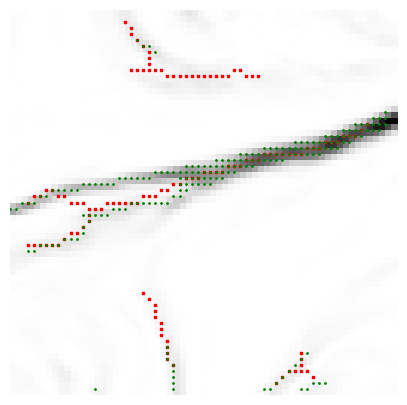

In [167]:
#plot_fronts(idx, boa, res_fronts=res_fronts)
plot_fronts(idx, boa, res_fronts=res_frnt2, thin=True)

<Axes: >

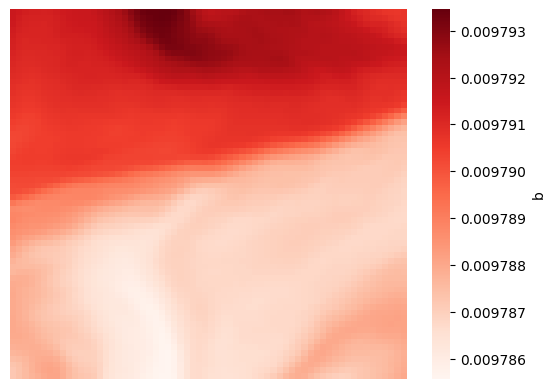

In [58]:
cutout.show_image(np.flipud(pp_fields[0]), cm='Reds', clbl='b')

## Examine the sobel

<Axes: >

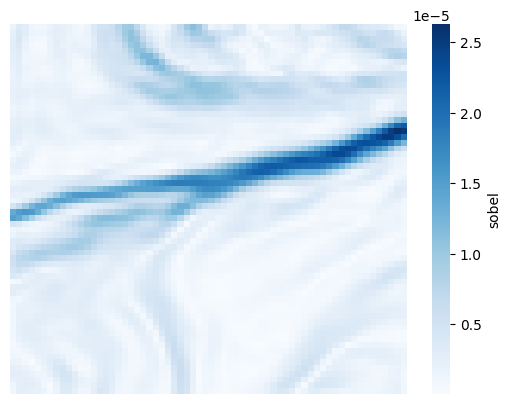

In [62]:
cutout.show_image(np.flipud(boa.isel(time=0).data_sobel), cm='Blues', clbl='sobel')

## Apply to $|\nabla b|^2$ image

In [152]:
divb2_ds = arr_to_dataset(pp_fields2[0])
pyboa_b2 = pyBOA.pyBOA(divb2_ds)
#res_frnt = pyboa_b2.front_trsh(prcnt=80).pyBOA.thinning(f_dilate=True)

In [153]:
res_frnt2 = pyboa_b2.front_trsh(prcnt=90)
#res_ds = arr_to_dataset(res_frnt.isel(time=0).data.data)
#res_pyboa = pyBOA.pyBOA(res_ds)
#res_frnt = res_pyboa.thinning(f_dilate=True)
#res_frnt
#res_pyboa._array
#res_frnt2 = res_pyboa.thinning(f_dilate=True)

In [154]:
res_frnt2

<xarray.Dataset> Size: 5kB
Dimensions:    (latitude: 64, longitude: 64, time: 1)
Coordinates:
  * latitude   (latitude) int64 512B 0 1 2 3 4 5 6 7 ... 56 57 58 59 60 61 62 63
  * longitude  (longitude) int64 512B 0 1 2 3 4 5 6 7 ... 57 58 59 60 61 62 63
Dimensions without coordinates: time
Data variables:
    data       (time, latitude, longitude) bool 4kB False False ... False False

In [155]:
np.sum(res_frnt2)

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    data     int64 8B 368

In [157]:
def thinning(in_array, iteration=2, f_dilate=True, min_size=7):
    array = in_array.copy()
    for t in range(len(array.time)):
        frnt = array[t, :, :].squeeze()  # make it work with .sel(time=t)
        if f_dilate:
            # dilate
            frnt = morphology.dilation(frnt)
        for it in range(iteration):
            # morphological thining
            frnt = morphology.thin(frnt)
            # spur removal
            frnt[frnt > 1] = 1
            frnt = pyBOA.spur(frnt, n_iter=1)
            # clean small object
            frnt = morphology.remove_small_objects(
                frnt.astype(bool), min_size=min_size, connectivity=2
            )
            # remove small holes
            frnt = morphology.remove_small_holes(frnt)
            if it < iteration - 1:
                # dilate
                frnt = morphology.dilation(frnt)
        frnt = morphology.thin(frnt)
        array[t, :, :] = frnt  # .sel(time=t)
    # 
    return array

In [158]:
res_fronts = thinning(res_frnt2.data, iteration=1)
res_fronts

<xarray.DataArray 'data' (time: 1, latitude: 64, longitude: 64)> Size: 4kB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]],
      shape=(1, 64, 64))
Coordinates:
  * latitude   (latitude) int64 512B 0 1 2 3 4 5 6 7 ... 56 57 58 59 60 61 62 63
  * longitude  (longitude) int64 512B 0 1 2 3 4 5 6 7 ... 57 58 59 60 61 62 63
Dimensions without coordinates: time

In [114]:
np.sum(res_fronts.isel(time=0).data)

np.int64(134)

----

<Axes: >

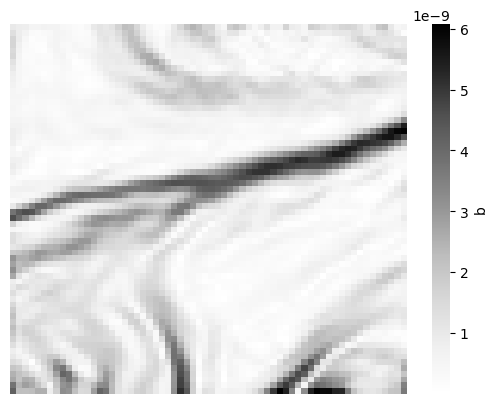

In [123]:
cutout.show_image(np.flipud(pp_fields2[0]/boa.isel(time=0).data_sobel), cm='Grays', clbl='b')